# Recognition of Affective State Through Facial Expressions 
## Members
- DICHOSO, Aaron Gabrielle C.
- NATIVIDAD, Josh Austin Mikhail T.
- RAZON, Luis Miguel Antonio B.

# AffectNet
**Dataset Description** (from [link](https://paperswithcode.com/dataset/affectnet))\
AffectNet is a large facial expression dataset with around 0.4 million images manually labeled for the presence of eight (neutral, happy, angry, sad, fear, surprise, disgust, contempt) facial expressions along with the intensity of valence and arousal.

This dataset retrieved was already pre-processed by [Noam Segal](https://www.kaggle.com/noamsegal) for the purpose of machine learning. All images were reduced to 96 x 96 pixels, and cropped to the face. Some monochromatic images were removed through the use of Principal Component Analysis.

**Notebook Description**\
This notebook utilizes the AffectNet Dataset to create a model focused on the recognition of four emotions (happy, sad, angry, and neutral) based on the given facial expression features extracted by the OpenCV library.

# Libraries
These libraries were used in the development of this notebook.

In [1]:
# If you are accessing this notebook for the first time without the necessary libraries, run this code block to download them.

#!pip install opencv-python
#!pip install --upgrade pip
#!pip install mtcnn
#!pip install mediapipe
#!pip install tensorflow
#!pip install pandas
#!pip install scikit-learn
#!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [2]:
import pandas as pd
from random import randint
from random import randrange
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import statistics
from mtcnn import MTCNN
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Data Import and Visualization

The file `cleaned_faces.csv` contain the cleaned data from the AffectNet dataset. Execution of this notebook **requires** that the previous notebook: `1. AffectNet Data Cleaning Notebook` be executed all the way to the end first.

In [3]:
cleaned_faces_df = pd.read_csv('outputs/cleaned_faces.csv')
cleaned_faces_df = cleaned_faces_df.drop(columns=['Unnamed: 0', 'relFCs', 'faceDetected', 'numFaces'])
cleaned_faces_df

,pth,label
0,anger/image0000060.jpg,anger
1,anger/image0000106.jpg,anger
2,anger/image0000132.jpg,anger
3,anger/image0000138.jpg,anger
4,anger/image0000195.jpg,anger
...,...,...
9101,surprise/image0034829.jpg,happy
9102,surprise/image0034831.jpg,neutral
9103,surprise/image0034931.jpg,happy
9104,surprise/image0034939.jpg,neutral


# 2. Data Modeling

## 2.1 Data Augmentation

To enhance the value of our data, data augmentation will be performed. For the case of image data containing faces, the ata will be augmented by duplicating a random amount of images and applying image processing operations on them, such as rotating the image by a random number of degrees and flipping certain images along the vertical axis.

In [4]:
augmented_data_df = cleaned_faces_df.copy(deep=True)
augmented_data_df

,pth,label
0,anger/image0000060.jpg,anger
1,anger/image0000106.jpg,anger
2,anger/image0000132.jpg,anger
3,anger/image0000138.jpg,anger
4,anger/image0000195.jpg,anger
...,...,...
9101,surprise/image0034829.jpg,happy
9102,surprise/image0034831.jpg,neutral
9103,surprise/image0034931.jpg,happy
9104,surprise/image0034939.jpg,neutral


In [5]:
import decimal
def augment_image(image):
    return rand_rotate_image(rand_flip_image(image))

def rand_flip_image(image):
    chance = randint(0, 1)
    if chance == 0:
        return image
    else:
        print("Image Flipped!")
        return cv2.flip(image, 1)

def rand_rotate_image(image):
    angle = 0
    while angle == 0:
        angle = float(decimal.Decimal(randrange(-150, 150))/10)

    print("Image rotated by", angle, "degrees")
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result

def augment_row(row, df, folder_name):
    base_path = "./dataset/"
    
    image_path = base_path + row['pth']
    image = cv2.imread(image_path)
    print("====================================")
    print(image_path)

    #Augmentation Here!
    image = augment_image(image)

    #Create new path to save images to
    new_path = folder_name + '/' + row['pth'].split("/")[1]
    print("New Path:", new_path)
    df.loc[index, 'pth'] = new_path
    
    #Save images here!
    cv2.imwrite(base_path + new_path, image)

In [6]:
#Augment a third of our dataset
edited_images_df = augmented_data_df.sample(frac=1/3)

#Go through each image to augment and access their file
for index, row in edited_images_df.iterrows():
    augment_row(row, edited_images_df, "augmented")

edited_images_df

./dataset/neutral/ffhq_3799.png
Image rotated by -6.9 degrees
New Path: augmented/ffhq_3799.png
./dataset/happy/ffhq_590.png
Image Flipped!
Image rotated by 12.1 degrees
New Path: augmented/ffhq_590.png
./dataset/anger/image0023084.jpg
Image Flipped!
Image rotated by 11.2 degrees
New Path: augmented/image0023084.jpg
./dataset/happy/ffhq_1919.png
Image Flipped!
Image rotated by -0.5 degrees
New Path: augmented/ffhq_1919.png
./dataset/neutral/ffhq_418.png
Image Flipped!
Image rotated by -2.4 degrees
New Path: augmented/ffhq_418.png
./dataset/sad/image0030113.jpg
Image rotated by 9.8 degrees
New Path: augmented/image0030113.jpg
./dataset/neutral/ffhq_714.png
Image rotated by 10.1 degrees
New Path: augmented/ffhq_714.png
./dataset/contempt/image0001968.jpg
Image rotated by 6.0 degrees
New Path: augmented/image0001968.jpg
./dataset/happy/ffhq_4626.png
Image rotated by -4.5 degrees
New Path: augmented/ffhq_4626.png
./dataset/anger/image0026875.jpg
Image Flipped!
Image rotated by 14.7 degrees

,pth,label
6426,augmented/ffhq_3799.png,neutral
5259,augmented/ffhq_590.png,happy
892,augmented/image0023084.jpg,anger
3140,augmented/ffhq_1919.png,happy
6601,augmented/ffhq_418.png,neutral
...,...,...
4280,augmented/ffhq_3644.png,happy
707,augmented/image0020375.jpg,anger
9051,augmented/image0032263.jpg,neutral
3893,augmented/ffhq_3064.png,happy


In [7]:
augmented_data_df = pd.concat([augmented_data_df, edited_images_df])
augmented_data_df

,pth,label
0,anger/image0000060.jpg,anger
1,anger/image0000106.jpg,anger
2,anger/image0000132.jpg,anger
3,anger/image0000138.jpg,anger
4,anger/image0000195.jpg,anger
...,...,...
4280,augmented/ffhq_3644.png,happy
707,augmented/image0020375.jpg,anger
9051,augmented/image0032263.jpg,neutral
3893,augmented/ffhq_3064.png,happy


## 2.2 Oversampling

There is an unequal amount of image data associated for each emotion. Using such a dataset may lead to the skewing of results in favor of emotions with a higher amount of data. As such, oversampling is needed to provide an equal amount of data for each associated emotion.

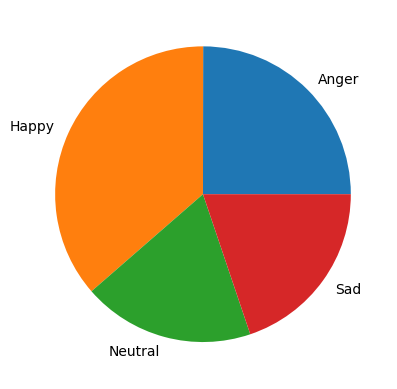

In [8]:
sum_df = augmented_data_df.groupby(['label']).count()
plt.pie(sum_df['pth'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show()

This module will be used to oversample images according to the highest amount of images in an emotion label. This is needed so that during the training portion of the emotion recognition model, it's emotion recognition functionality may not be skewed favoring one emotion.

The method of oversampling will be performed by generating new image data through random transformations similar to those performed in Data Augmentation.

In [9]:
dict_df_emotions = {
    "happy" :  augmented_data_df[augmented_data_df['label'] == 'happy'],
    "sad" : augmented_data_df[augmented_data_df['label'] == 'sad'],
    "anger" : augmented_data_df[augmented_data_df['label'] == 'anger'],
    "neutral" : augmented_data_df[augmented_data_df['label'] == 'neutral']
}

dict_counts = {
    "happy" : dict_df_emotions['happy'].shape[0],
    "sad" : dict_df_emotions['sad'].shape[0],
    "anger" : dict_df_emotions['anger'].shape[0],
    "neutral" : dict_df_emotions['neutral'].shape[0]
}

dict_counts = dict(sorted(dict_counts.items(), key = lambda item : item[1],  reverse = True))
dict_counts

{'happy': 4422, 'anger': 3033, 'sad': 2406, 'neutral': 2280}

In [10]:
#Step 3: Get number of oversampled images needed for each emotion
highest_count = dict_counts[list(dict_counts)[0]]

print(highest_count)

oversampling_count = {
    "happy" : highest_count - dict_df_emotions['happy'].shape[0],
    "sad" : highest_count - dict_df_emotions['sad'].shape[0],
    "anger" : highest_count - dict_df_emotions['anger'].shape[0],
    "neutral" : highest_count - dict_df_emotions['neutral'].shape[0]
}

oversampling_count

4422


{'happy': 0, 'sad': 2016, 'anger': 1389, 'neutral': 2142}

In [11]:
#Step 4: for each emotion, generate new images according to oversampling count

for emotion in list(oversampling_count):
    print("=======!!!", emotion, oversampling_count[emotion],"!!!=======")
    added_rows_df = dict_df_emotions[emotion].sample(n=oversampling_count[emotion])

    for index, row in added_rows_df.iterrows():
        augment_row(row, added_rows_df, 'oversampled')
    
    print("Count:", added_rows_df.shape[0])
    
    dict_df_emotions[emotion] = pd.concat([dict_df_emotions[emotion], added_rows_df])
    
    print("New Count:", dict_df_emotions[emotion].shape[0])
    
    added_rows_df.drop(added_rows_df.index , inplace=True)

=======!!! happy 0 !!!=======
Count: 0
New Count: 4422
=======!!! sad 2016 !!!=======
./dataset/sad/image0030355.jpg
Image rotated by -2.9 degrees
New Path: oversampled/image0030355.jpg
./dataset/surprise/image0002003.jpg
Image rotated by -6.7 degrees
New Path: oversampled/image0002003.jpg
./dataset/augmented/image0013616.jpg
Image Flipped!
Image rotated by -4.8 degrees
New Path: oversampled/image0013616.jpg
./dataset/augmented/image0024724.jpg
Image Flipped!
Image rotated by 3.4 degrees
New Path: oversampled/image0024724.jpg
./dataset/augmented/image0029810.jpg
Image rotated by 5.8 degrees
New Path: oversampled/image0029810.jpg
./dataset/anger/image0016348.jpg
Image rotated by -11.1 degrees
New Path: oversampled/image0016348.jpg
./dataset/sad/image0022997.jpg
Image Flipped!
Image rotated by 4.4 degrees
New Path: oversampled/image0022997.jpg
./dataset/sad/image0013792.jpg
Image rotated by -1.7 degrees
New Path: oversampled/image0013792.jpg
./dataset/anger/image0002524.jpg
Image Flipped

In [12]:
#Last step: merge all emotions back
dfs = [dict_df_emotions['happy'], dict_df_emotions['sad'], dict_df_emotions['anger'], dict_df_emotions['neutral']]
new_faces_df_1 = pd.concat(dfs)
new_faces_df_1

#remove "Unnamed: 0" column and reset index
new_faces_df_1.reset_index(drop=True, inplace=True)
new_faces_df_1.head()

,pth,label
0,anger/image0001956.jpg,happy
1,anger/image0004504.jpg,happy
2,anger/image0006510.jpg,happy
3,anger/image0009562.jpg,happy
4,anger/image0012970.jpg,happy


<function matplotlib.pyplot.show(close=None, block=None)>

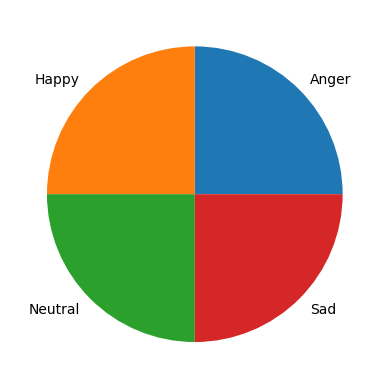

In [13]:
sum_df = new_faces_df_1.groupby(['label']).count()
plt.pie(sum_df['pth'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show

In [14]:
oversampled_data_df = new_faces_df_1.copy(deep=True)

## 2.2 Making mirrored faces

After oversampling, all the images will be duplicated and mirrored to cover for all orientations of a face showing an emotion.

In [15]:
import decimal
def mirror_image(image):
    return cv2.flip(image, 1)
    
def mirror_row(row, df):
    base_path = "./dataset/"
    
    image_path = base_path + row['pth']
    image = cv2.imread(image_path)

    #Augmentation Here!
    image = mirror_image(image)

    #Create new path to save images to
    new_path = 'mirrored' + '/' + row['pth'].split("/")[0]+"_"+row['pth'].split("/")[1]
    print("New Path:", new_path)
    df.loc[index, 'pth'] = new_path
    
    #Save images here!
    cv2.imwrite(base_path + new_path, image)

In [16]:
mirrored_data_df = oversampled_data_df.copy(deep=True)
for index, row in mirrored_data_df.iterrows():
        mirror_row(row, mirrored_data_df)

oversampled_data_df = pd.concat([oversampled_data_df, mirrored_data_df]).reset_index()
oversampled_data_df

New Path: mirrored/anger_image0001956.jpg
New Path: mirrored/anger_image0004504.jpg
New Path: mirrored/anger_image0006510.jpg
New Path: mirrored/anger_image0009562.jpg
New Path: mirrored/anger_image0012970.jpg
New Path: mirrored/anger_image0018338.jpg
New Path: mirrored/anger_image0019052.jpg
New Path: mirrored/anger_image0021140.jpg
New Path: mirrored/anger_image0021412.jpg
New Path: mirrored/anger_image0027616.jpg
New Path: mirrored/anger_image0029594.jpg
New Path: mirrored/contempt_ffhq_30.png
New Path: mirrored/contempt_ffhq_76.png
New Path: mirrored/contempt_ffhq_93.png
New Path: mirrored/contempt_ffhq_94.png
New Path: mirrored/contempt_ffhq_95.png
New Path: mirrored/contempt_image0000337.jpg
New Path: mirrored/contempt_image0001046.jpg
New Path: mirrored/contempt_image0001968.jpg
New Path: mirrored/contempt_image0002270.jpg
New Path: mirrored/contempt_image0003199.jpg
New Path: mirrored/contempt_image0003243.jpg
New Path: mirrored/contempt_image0005444.jpg
New Path: mirrored/cont

,index,pth,label
0,0,anger/image0001956.jpg,happy
1,1,anger/image0004504.jpg,happy
2,2,anger/image0006510.jpg,happy
3,3,anger/image0009562.jpg,happy
4,4,anger/image0012970.jpg,happy
...,...,...,...
35371,17683,mirrored/oversampled_ffhq_2310.png,neutral
35372,17684,mirrored/oversampled_ffhq_5002.png,neutral
35373,17685,mirrored/oversampled_ffhq_2838.png,neutral
35374,17686,mirrored/oversampled_ffhq_4807.png,neutral


## 2.3 Extracting Facial Landmarks

After the dataset has been processed, it is now possible to extract the facial landmarks that will be used by a machine learning model for the prediction of the given emotion labels.

Different machine learning models will be utilized to test different approaches in terms of speed and performance in classification problems.

### 1st Model Approach: [Mediapipe Facial Landmark Detection Model](https://developers.google.com/mediapipe/solutions/vision/face_landmarker)
The Mediapipe Face Landmarker uses machine learning models to create a face mesh that outputs an estimate of 478 3-dimensional face landmarks. The large amount of facial landmarks generated by this model serve as rich representations of the facial expressions. It is able to capture the key points and positions of each part of the face, such as the eyebrows, eyes, nose, and mouth, and even the small details such as the forehead, cheeks, and jaw, allowing the model to provide a comprehensive analysis of facial expressions.

Before extracting the facial landmarks of every face in the dataset, the model was first tested on an image not part of the database.

In [17]:
#visualization utilities retrieved from mediapipe documentation:
#https://github.com/googlesamples/mediapipe/blob/main/examples/face_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Face_Landmarker.ipynb

def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.5743138790130615, y=0.6889077425003052, z=-0.0757405161857605, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5861771702766418, y=0.6081040501594543, z=-0.11635051667690277, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5806379318237305, y=0.6360802054405212, z=-0.06825906038284302, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5728011727333069, y=0.5384976863861084, z=-0.07820826768875122, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5886233448982239, y=0.5850725769996643, z=-0.12065678834915161, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5904492139816284, y=0.5581714510917664, z=-0.10794224590063095, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5934493541717529, y=0.49504899978637695, z=-0.0367915965616703, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.43090513348579407, y=0.47988396883010864, z=0.03688709810376167, visibility=0.0, presence=0.0), NormalizedLandmark

(-0.5, 942.5, 942.5, -0.5)

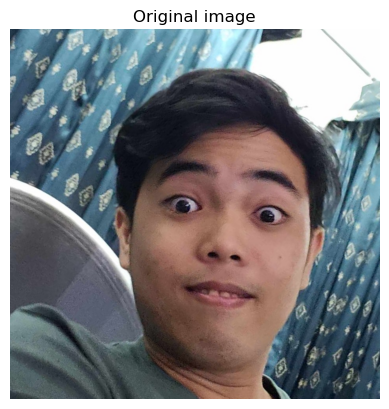

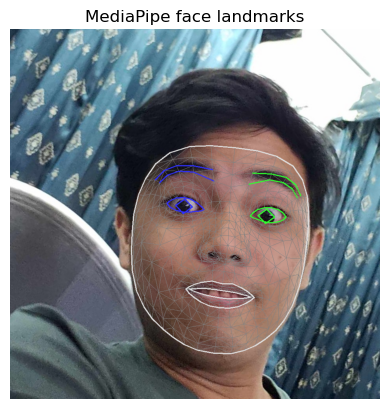

In [18]:
#Model Setup
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)

#Test the model
detector2 = vision.FaceLandmarker.create_from_options(options)               
image = mp.Image.create_from_file("./mediapipe_test.jpg")
detection_result = detector2.detect(image) #this is the line

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print(detection_result)
#original image
plt.figure()
plt.imshow(image.numpy_view())
plt.title('Original image')
plt.axis('off')
#annotated image
plt.figure()
plt.imshow(annotated_image)
plt.title('MediaPipe face landmarks')
plt.axis('off')

#display the resulting coordinates of each landmark


In [19]:
print("Obtained Landmarks")
print(detection_result.face_landmarks[0][0].x, detection_result.face_landmarks[0][0].y, detection_result.face_landmarks[0][0].z)
print('Count: ', len(detection_result.face_landmarks[0]))

Obtained Landmarks
0.5743138790130615 0.6889077425003052 -0.0757405161857605
Count:  478


## 2.4 Appending Facial Landmark Values in `oversampled_data_df`

In [20]:
i = 0
base_path = "./dataset/"
# add a 'landmarks' column to the dataframe
oversampled_data_df['landmarks'] = None
for idx, row in oversampled_data_df.iterrows():
    face_img = mp.Image.create_from_file(base_path + row['pth'])
    detection_result = detector2.detect(face_img)
    
    #if no face detected, drop the row
    if len(detection_result.face_landmarks) <= 0:
        oversampled_data_df.drop(index=idx, inplace=True)
        continue
    #turn it into a list of tuples with the x, y, z coordinates
    oversampled_data_df.at[idx, 'landmarks'] = [ (landmark.x, landmark.y, landmark.z) for landmark in detection_result.face_landmarks[0] ]

In [21]:
oversampled_data_df.to_csv('outputs\oversampled_faces_with_landmarks_mediapipe.csv', index=False, header=True, encoding='utf-8')

### Optional: Importing
use the code block below to reimport data of faces with facial landmarks extracted, as long as no changes were performed.

In [22]:
landmarks_faces_df = pd.read_csv('outputs\oversampled_faces_with_landmarks_mediapipe.csv')
#parse the landmarks column to a list of tuples
landmarks_faces_df['landmarks'] = landmarks_faces_df['landmarks'].apply(eval)

## 2.5 Dataset splitting

Finally, the dataset can now be split into train and test sets.

In [23]:
landmarks_faces_df

,index,pth,label,landmarks
0,0,anger/image0001956.jpg,happy,"[(0.5075767636299133, 0.6905035972595215, -0.0..."
1,1,anger/image0004504.jpg,happy,"[(0.506913423538208, 0.6853656768798828, -0.05..."
2,2,anger/image0006510.jpg,happy,"[(0.5290422439575195, 0.6751238107681274, -0.0..."
3,3,anger/image0009562.jpg,happy,"[(0.5999926328659058, 0.7471040487289429, -0.0..."
4,4,anger/image0012970.jpg,happy,"[(0.4938056170940399, 0.7192921042442322, -0.0..."
...,...,...,...,...
35324,17683,mirrored/oversampled_ffhq_2310.png,neutral,"[(0.5659758448600769, 0.704839289188385, -0.04..."
35325,17684,mirrored/oversampled_ffhq_5002.png,neutral,"[(0.4660402238368988, 0.702263593673706, -0.05..."
35326,17685,mirrored/oversampled_ffhq_2838.png,neutral,"[(0.46601274609565735, 0.7176843881607056, -0...."
35327,17686,mirrored/oversampled_ffhq_4807.png,neutral,"[(0.553207278251648, 0.6844416856765747, -0.08..."


The order of entries in the rows will first be randomized to prevent possible skewing of results

In [24]:
landmarks_faces_df = landmarks_faces_df.sample(frac=1).reset_index(drop=True)
landmarks_faces_df

,index,pth,label,landmarks
0,14854,sad/image0027897.jpg,neutral,"[(0.502577006816864, 0.7314062714576721, -0.10..."
1,14641,mirrored/neutral_ffhq_786.png,neutral,"[(0.46797457337379456, 0.7252950072288513, -0...."
2,17021,mirrored/oversampled_image0040797.jpg,neutral,"[(0.4163152575492859, 0.6629041433334351, -0.0..."
3,5159,mirrored/sad_image0002061.jpg,sad,"[(0.47304588556289673, 0.6967278718948364, -0...."
4,10521,mirrored/neutral_ffhq_1135.png,anger,"[(0.5246003270149231, 0.6992490887641907, -0.0..."
...,...,...,...,...
35324,14346,neutral/ffhq_4586.png,neutral,"[(0.5029144287109375, 0.7150818109512329, -0.0..."
35325,570,happy/ffhq_1534.png,happy,"[(0.4966210424900055, 0.6728988289833069, -0.0..."
35326,6028,mirrored/sad_image0028479.jpg,sad,"[(0.5005812644958496, 0.6963198184967041, -0.0..."
35327,4064,mirrored/augmented_ffhq_2791.png,happy,"[(0.5334652066230774, 0.7099053263664246, -0.0..."


After which, 20% of rows will be used for test data, while 80% will be used for training data

In [25]:
model_training_df = landmarks_faces_df[['label','landmarks']]
model_training_df.reset_index(inplace=True, drop=True)
model_training_df

,label,landmarks
0,neutral,"[(0.502577006816864, 0.7314062714576721, -0.10..."
1,neutral,"[(0.46797457337379456, 0.7252950072288513, -0...."
2,neutral,"[(0.4163152575492859, 0.6629041433334351, -0.0..."
3,sad,"[(0.47304588556289673, 0.6967278718948364, -0...."
4,anger,"[(0.5246003270149231, 0.6992490887641907, -0.0..."
...,...,...
35324,neutral,"[(0.5029144287109375, 0.7150818109512329, -0.0..."
35325,happy,"[(0.4966210424900055, 0.6728988289833069, -0.0..."
35326,sad,"[(0.5005812644958496, 0.6963198184967041, -0.0..."
35327,happy,"[(0.5334652066230774, 0.7099053263664246, -0.0..."


In [26]:
# Extract x, y, and z coordinates from the tuples in the 'landmarks' column
coordinates = model_training_df['landmarks'].apply(lambda x: [coord for landmark in x for coord in landmark])

# Create a DataFrame from the extracted coordinates
landmarks_df = pd.DataFrame(coordinates.tolist(), columns=[f'lm_{i+1}_{coord}' for i in range(len(coordinates.iloc[0]) // 3) for coord in ['x', 'y', 'z']])

# Concatenate the original DataFrame with the new landmarks DataFrame
model_training_df = pd.concat([model_training_df, landmarks_df], axis=1)

# Drop the original 'landmarks' column
model_training_df.drop(columns=['landmarks'], inplace=True)
model_training_df.head()

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
0,neutral,0.502577,0.731406,-0.107596,0.510800,0.596504,-0.186502,0.508591,0.640742,-0.100808,...,0.038188,0.686589,0.379847,0.038191,0.651997,0.406664,0.038147,0.682836,0.437380,0.038155
1,neutral,0.467975,0.725295,-0.041434,0.450111,0.635940,-0.120409,0.463704,0.654938,-0.052039,...,-0.048573,0.638827,0.443919,-0.048573,0.614141,0.465228,-0.048599,0.638105,0.488861,-0.048595
2,neutral,0.416315,0.662904,-0.061636,0.458453,0.584466,-0.125229,0.448826,0.601128,-0.063802,...,0.009759,0.639993,0.487920,0.009761,0.613010,0.494118,0.009735,0.621065,0.520481,0.009739
3,sad,0.473046,0.696728,-0.091748,0.496471,0.604488,-0.168070,0.487032,0.632623,-0.092936,...,0.045890,0.670601,0.442534,0.045891,0.639195,0.458482,0.045855,0.660743,0.485365,0.045862
4,anger,0.524600,0.699249,-0.081528,0.529490,0.604134,-0.129072,0.522681,0.636452,-0.074002,...,0.058010,0.614887,0.446064,0.058014,0.592219,0.464361,0.057986,0.613989,0.483606,0.057991


In [27]:
#Splitting of data into train and test sets, 
train_set = model_training_df.sample(frac=0.8)
train_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
14238,sad,0.513179,0.678886,-0.070686,0.513514,0.592707,-0.141227,0.511918,0.619946,-0.072883,...,0.022432,0.623208,0.395030,0.022432,0.602510,0.415301,0.022399,0.624148,0.434169,0.022405
14327,sad,0.432616,0.731442,-0.027274,0.459280,0.657349,-0.137103,0.454085,0.668750,-0.055807,...,-0.023335,0.687875,0.424933,-0.023341,0.654600,0.440762,-0.023374,0.673154,0.471371,-0.023370
26418,anger,0.492814,0.688951,-0.052054,0.495235,0.607555,-0.127564,0.495412,0.628930,-0.059955,...,0.004979,0.607206,0.374816,0.004982,0.584380,0.402314,0.004949,0.611456,0.425760,0.004956
34270,sad,0.440305,0.654108,-0.076379,0.435762,0.566327,-0.134616,0.442255,0.594352,-0.072537,...,-0.002841,0.592488,0.397122,-0.002844,0.566615,0.418175,-0.002872,0.587009,0.442633,-0.002868
17359,anger,0.483112,0.740724,-0.049972,0.489535,0.657877,-0.148269,0.487954,0.676218,-0.063542,...,-0.028191,0.649790,0.391838,-0.028188,0.615861,0.418991,-0.028226,0.645418,0.451289,-0.028220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9564,neutral,0.477263,0.692715,-0.066002,0.489346,0.612259,-0.121995,0.484836,0.635158,-0.062243,...,0.021573,0.624767,0.460005,0.021576,0.594904,0.479761,0.021547,0.618256,0.506687,0.021553
18820,neutral,0.471652,0.714590,-0.076435,0.462307,0.602703,-0.125300,0.470909,0.635367,-0.071050,...,-0.007591,0.623093,0.435631,-0.007594,0.598326,0.456944,-0.007617,0.621999,0.479413,-0.007614
33132,anger,0.507167,0.710091,-0.095041,0.504470,0.603731,-0.161574,0.508617,0.634923,-0.090739,...,0.020486,0.688788,0.384900,0.020489,0.658231,0.409409,0.020451,0.687828,0.434987,0.020458
8559,happy,0.486694,0.696824,-0.078026,0.483353,0.613361,-0.137368,0.486065,0.639882,-0.077562,...,0.013279,0.622566,0.446390,0.013277,0.598895,0.466080,0.013253,0.623005,0.485286,0.013257


In [28]:
test_set = pd.concat([model_training_df,train_set]).drop_duplicates(keep=False)
test_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_475_z,lm_476_x,lm_476_y,lm_476_z,lm_477_x,lm_477_y,lm_477_z,lm_478_x,lm_478_y,lm_478_z
3,sad,0.473046,0.696728,-0.091748,0.496471,0.604488,-0.168070,0.487032,0.632623,-0.092936,...,0.045890,0.670601,0.442534,0.045891,0.639195,0.458482,0.045855,0.660743,0.485365,0.045862
9,sad,0.492350,0.714685,-0.045139,0.539254,0.634724,-0.090736,0.501687,0.658425,-0.048153,...,0.064536,0.587501,0.457886,0.064539,0.563775,0.476562,0.064510,0.579370,0.502035,0.064516
13,happy,0.490669,0.726424,-0.042978,0.488736,0.653719,-0.136378,0.490637,0.671048,-0.063816,...,-0.013364,0.624411,0.444959,-0.013364,0.599321,0.465061,-0.013393,0.623082,0.486691,-0.013390
17,happy,0.487772,0.715298,-0.064368,0.496388,0.642020,-0.135233,0.493557,0.662816,-0.074048,...,0.018728,0.626525,0.459460,0.018728,0.600760,0.478731,0.018701,0.624030,0.500750,0.018706
19,anger,0.435017,0.681450,-0.019222,0.457655,0.626136,-0.113952,0.450812,0.634583,-0.041011,...,-0.019818,0.633409,0.419269,-0.019812,0.600469,0.436421,-0.019841,0.621377,0.467850,-0.019836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35312,anger,0.467074,0.711874,-0.066803,0.490944,0.603252,-0.139190,0.483111,0.631721,-0.069910,...,0.021422,0.644667,0.400973,0.021424,0.611448,0.424229,0.021390,0.635391,0.457057,0.021397
35315,anger,0.534954,0.675536,-0.061679,0.537082,0.602585,-0.165144,0.530123,0.622123,-0.084990,...,0.014990,0.644270,0.378498,0.014996,0.619339,0.399653,0.014956,0.647869,0.417729,0.014964
35317,sad,0.526639,0.603841,-0.079819,0.522552,0.541407,-0.123911,0.524735,0.568331,-0.071606,...,0.037879,0.624804,0.382451,0.037881,0.603936,0.403715,0.037855,0.628075,0.421386,0.037861
35323,happy,0.508241,0.732418,-0.038069,0.524389,0.678396,-0.128743,0.513136,0.690689,-0.060118,...,0.005707,0.614172,0.442669,0.005707,0.591247,0.464957,0.005678,0.614524,0.487100,0.005681


# 3. Exporting Datasets to CSV

Finally, we export the train and test datasets to be used in other notebooks that would use the datasets for implementing differnet models.

In [29]:
# Exporting Datasets
train_set.to_csv('outputs/train_set_augmented.csv', index=False, header=True, encoding='utf-8')

In [30]:
# Exporting Datasets
test_set.to_csv('outputs/test_set_augmented.csv', index=False, header=True, encoding='utf-8')